In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta, datetime

In [2]:
pop_covid_csv = pd.read_csv("caso_full.csv") #https://brasil.io/dataset/covid19/caso_full/

In [3]:
pop_covid = pop_covid_csv[(pop_covid_csv['place_type'] == 'city') & pop_covid_csv["city_ibge_code"].notna() ]
pop_covid = pop_covid[['date', 'state', 'city', 'estimated_population_2019', 'last_available_deaths']]
pop_covid['city'] = pop_covid['city'].str.replace("\'", " ")
pop_covid['city'] = pop_covid['city'].str.upper()
pop_covid['sizes'] = pop_covid['estimated_population_2019']/1e3 + 2
pop_covid = pop_covid.sort_values(['estimated_population_2019'], ascending=False)
pop_covid['death_per_million'] = pop_covid.apply (lambda row: 1e6*row['last_available_deaths']/row['estimated_population_2019'], axis=1)

In [4]:
eleicao_csv = pd.read_csv("votacao_partido_munzona_2018_BRASIL.csv", sep=';', encoding='latin1') #https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_partido_munzona/votacao_partido_munzona_2018.zip

In [5]:
eleicao = eleicao_csv[ (eleicao_csv.NR_TURNO != 1) & (eleicao_csv.DS_CARGO == 'Presidente') & (eleicao_csv.SG_UF != 'ZZ')]
eleicao = eleicao[['SG_UF', 'NM_MUNICIPIO', 'NR_PARTIDO', 'QT_VOTOS_NOMINAIS']]
eleicao = pd.pivot_table(eleicao, index=['SG_UF','NM_MUNICIPIO'], columns='NR_PARTIDO', aggfunc=np.sum)
eleicao = eleicao.reindex(eleicao['QT_VOTOS_NOMINAIS'].sort_values(by=17,ascending=False).index)
eleicao = pd.DataFrame(eleicao.to_records()).rename(columns={"SG_UF":"state", "NM_MUNICIPIO":"city", "('QT_VOTOS_NOMINAIS', 13)":'13',"('QT_VOTOS_NOMINAIS', 17)":'17'})
eleicao['rate_17'] = eleicao.apply ( lambda row: row['17']/(row['13']+row['17']), axis=1 )
eleicao['partido'] = eleicao.apply ( lambda row: '17' if (row['rate_17']>=0.50) else '13', axis=1 )
eleicao['colors'] = eleicao.apply (lambda row: int(1e2*row['rate_17']), axis=1)

In [6]:
pop_covid_eleicao = pd.merge(pop_covid, eleicao, on=['state', 'city'], how='left')
pop_covid_eleicao = pop_covid_eleicao[pop_covid_eleicao['partido'].notna()]

In [7]:
df = pop_covid_eleicao 
df['sizes'] = df['estimated_population_2019']/4e4 + 2

graf2020-02-25.png
graf2021-05-27.png


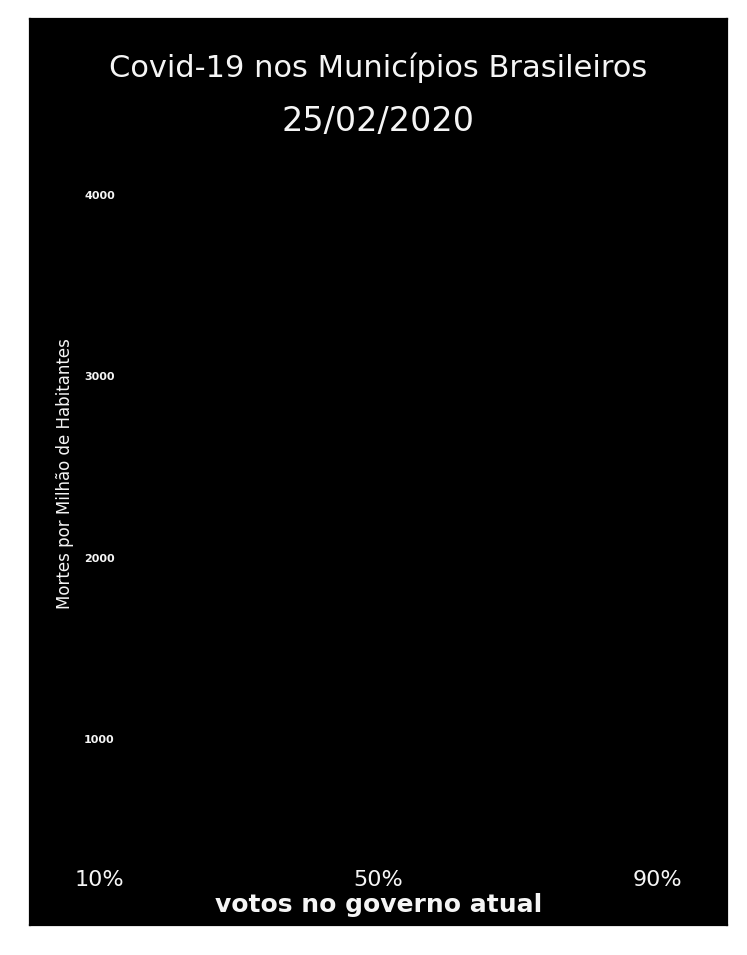

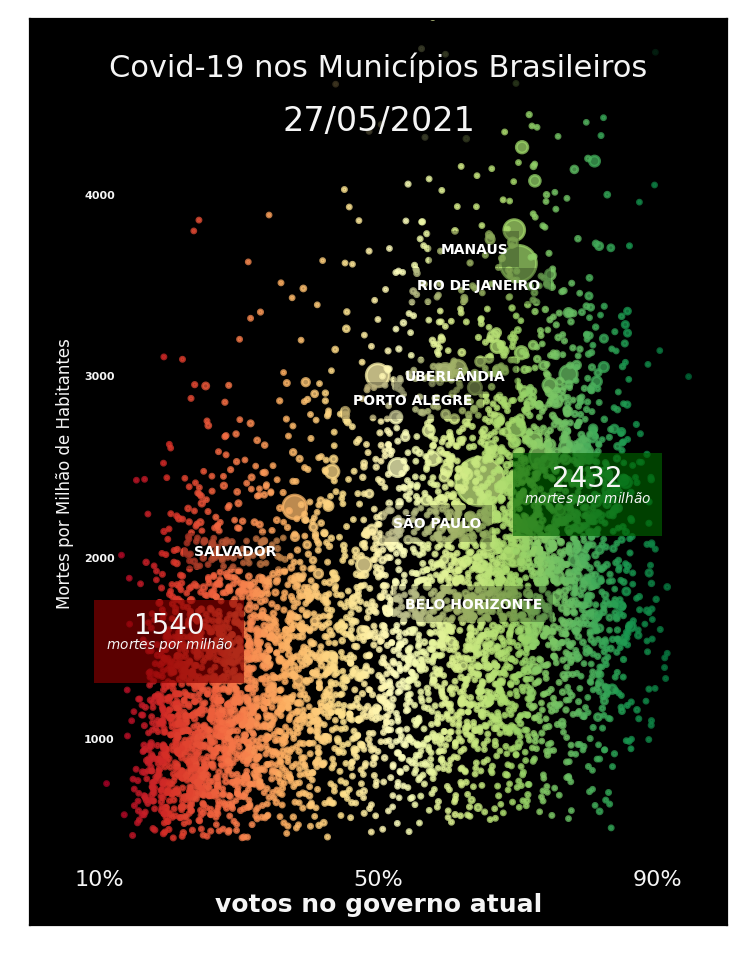

In [10]:
last = True #render only the first and the last frame
if last:
    dates = [datetime.strptime('2020-2-25', '%Y-%m-%d'),datetime.strptime('2021-5-27', '%Y-%m-%d')] #pd.date_range(start='2020-2-27', end='2020-2-27',freq='d')
else:
    dates = pd.date_range(start='2020-2-25', end='2021-5-27',freq='d')

for dt in dates:
    d = dt.strftime('%Y-%m-%d')
    dd = dt.strftime('%d/%m/%Y')
    ddate = df[ (df["date"] == d)]
    #dg = ddate[ddate['city'] == 'SÃO PAULO'] #filter a city
    dg = ddate[ddate['last_available_deaths'] > 0]
    dpm = 1e6*dg.groupby(['partido'])['last_available_deaths'].sum()/dg.groupby(['partido'])['estimated_population_2019'].sum()
    
    fig, ax = plt.subplots(figsize=(4.5, 6), dpi=200)
    ax.axis([-0.1, 0.99, -500, 5500])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set(facecolor='black')
    
    eixo_x = ax.text(0.50, 0.01, "votos no governo atual" , verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='whitesmoke', fontsize=9,  weight="bold")
    pcts = ['10%','50%','90%']
    pos = [0.1, 0.5, 0.9]
    for p in range(len(pcts)):
         ax.text(pos[p], 0.04, pcts[p] , verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='whitesmoke', fontsize=8)
    
    
    eixo_y = ax.text(0.05, 0.35, "Mortes por Milhão de Habitantes", verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='whitesmoke', fontsize=6, rotation=90)
    ys = [4000,3000,2000,1000]
    for y in ys:
        ax.text(0.1, y/5000, str(y), verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='whitesmoke', fontsize=4, weight="bold")
    
    tit = ax.text(0.5, 0.93, "Covid-19 nos Municípios Brasileiros", verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='whitesmoke', fontsize=11)
    tit.set_bbox(dict(facecolor='black', alpha=0.75, edgecolor='none'))    
    day = ax.text(0.50, 0.87, dd , verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='whitesmoke', fontsize=12)
    day.set_bbox(dict(facecolor='black', alpha=0.75, edgecolor='none'))

    ax.scatter(dg['rate_17'], dg['death_per_million'], s=dg['sizes'], c=dg['colors'], cmap='RdYlGn', alpha=0.75)    
    
    cidades = ['Manaus','Salvador','Rio de Janeiro','Belo Horizonte', 'São Paulo', 'Uberlândia', 'Porto Alegre']
    #cidades = []
    for cidade in cidades:
        c=cidade.upper()
        d1 = dg.loc[dg['city'] == c]
        if not(d1.empty): 
            d1 = d1.reset_index(drop=True).at[0,'death_per_million']
            if d1 >= 300:
                x1 = dg.loc[dg['city'] == c].reset_index(drop=True).at[0,'rate_17']-0.02
                y1 = d1/5500+0.0
                t1 = ax.text(x1,y1,c,verticalalignment='center', horizontalalignment='center', transform=ax.transAxes, color='white', fontsize=5, weight="bold")
                t1.set_bbox(dict(facecolor='black', alpha=0.25, edgecolor='none'))

    #mortes por milhão dois grupos
    dpm = 1e6*dg.groupby(['partido'])['last_available_deaths'].sum()/dg.groupby(['partido'])['estimated_population_2019'].sum()
    dpm = dpm.to_frame()
    tot = 0
    if not(dpm.empty):
        dpm[0] = dpm[0].apply(lambda x: int(x) if x == x else "")
        if '13' in dpm.index:
            dpm13 = dpm.loc['13']
            tot = tot + dpm13[0]
            a13 = dpm13[0]/5500
            if a13 > 0.09:
                t13 = ax.text(0.2,a13, str(dpm13[0])+'\n$^{^{mortes\ por\ milhão}}$', verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='whitesmoke', fontsize=10)
                t13.set_bbox(dict(facecolor='darkred', alpha=0.65, edgecolor='none'))
        if '17' in dpm.index:
            dpm17 = dpm.loc['17']
            tot = tot + dpm13[0]
            a17 = dpm17[0]/5500
            if a17 > 0.09:
                t17 = ax.text(0.8,a17, str(dpm17[0])+'\n$^{^{mortes\ por\ milhão}}$', verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='whitesmoke', fontsize=10)
                t17.set_bbox(dict(facecolor='darkgreen', alpha=0.65, edgecolor='none'))

    if not(last) :
        fig.savefig('covid5/graf' + d + '.png')
        plt.close(fig)
    print('graf' + d + '.png')